In [5]:
"""main.py

Main script for the CMS Run3 analysis
"""
%reset -f
%load_ext autoreload
%autoreload 2
import os
import sys
import pathlib

import numpy as np

import uproot
import awkward as ak
import awkward.numba

import ROOT as rt
from src import CMS_lumi, tdrstyle
from ROOT import TChain, TCanvas, TH1F, TH2F, TF1, TLatex, TGraph, RDataFrame, TLine, TBox
from src.histo_utilities import create_prof1D, create_TGraph, create_TH1D, create_TH2D, std_color_list
from src.helper_functions import (getRecoTime, find_nearest, deltaPhi, deltaR, lor, land, lxor, lnot, asum, canvas,
                                  weight_calc)

from main2 import MuonSystem, get_lat_leg

from main_030223 import H1D, multi_plot, fix_nclusters, match_clusters, pass_NCSC_NDT, pass_muon_veto, pass_jet_veto, pass_in_time, pass_L1, pass_in_det

########################################################

out_dir = '/home/psimmerl/Documents/CMS/LLP/reports/weekly/mar2/'
data_dir = '/home/psimmerl/Documents/CMS/LLP/data/raw/'

file_db_0p4 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v4.root'
file_ca_0p4 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v5.root'
file_ca_0p5 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v7.root'
file_ca_0p6 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
file_ca_0p8 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v8.root'
file_ca_1p0 = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v9.root'
# run3_file = data_dir + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'

files = [file_db_0p4, file_ca_0p4, file_ca_0p5, file_ca_0p6, file_ca_0p8, file_ca_1p0]
labels = [
    'DBSCAN',
    'CA 0.4',
    'CA 0.5',
    'CA 0.6',
    'CA 0.8',
    'CA 1.0',
]
tree_name = 'MuonSystem'
ending = '.png'

dets = ['CSC', 'DT']
pi = rt.TMath.Pi()
met = False
gc = []

is_mc = 'DisplacedJet' not in files[0]

rt.gROOT.SetBatch()

a = tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0
rt.gStyle.SetOptFit(0)  #1011)

pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)  # make out directory if it doesn't exist

print(f'Using output directory \'{out_dir}\'')
print(f'Processing tree \'{tree_name}\':')  # from \'{file_in}\':')
print(f'\tTreating file as {"MC" if is_mc else "DATA"}')

fuproots = [uproot.open(ff + ':' + tree_name) for ff in files]
mss = [fup.arrays() for fup in fuproots]
print('Requiring gLLP to decay in CSC.')
mss = [pass_in_det(ms) for ms in mss]
mss_matched = [pass_NCSC_NDT(match_clusters(ms), ncsc=1, ndt=0) for ms in mss]



# if not is_mc:
# print('REMOVING ALL EVENTS WITH N CLUSTERS > 2')
# mss = [ms[(ms['nCscRechitClusters'] + ms['nDtRechitClusters']) <= 2] for ms in mss]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using output directory '/home/psimmerl/Documents/CMS/LLP/reports/weekly/mar2/'
Processing tree 'MuonSystem':
	Treating file as MC
Requiring gLLP to decay in CSC.


Info in <TCanvas::Print>: png file /home/psimmerl/Documents/CMS/LLP/reports/weekly/mar2/eff_compare_DBSCAN-CA.png has been created


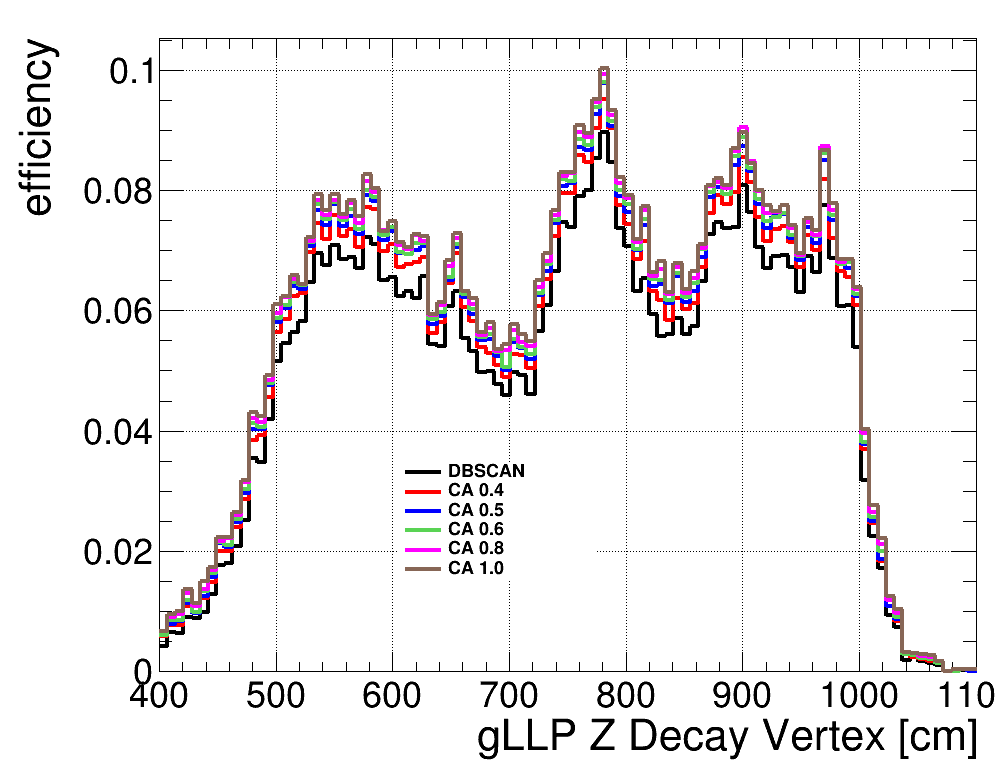

In [9]:
c = canvas()
title = ';gLLP Z Decay Vertex [cm];efficiency'
bins = (100, 400, 1100)
nums = [H1D(np.abs(ms['cscRechitCluster_match_gLLP_decay_z']), title, bins=bins) for ms in mss_matched]
dens = [H1D(np.abs(ms['gLLP_decay_vertex_z']), title, bins=bins) for ms in mss]
for num, den in zip(nums, dens):
    num.Divide(den)

_ = multi_plot(nums, labels, legxy=(0.4,0.25,0.6,0.4))
# CMS_lumi.CMS_lumi(c.cd(), 9999, 10)
c.Print(out_dir + 'eff_compare_DBSCAN-CA' + ending)